# Visualizing IPC Code Evolution

Copyright 2020, Sanjay Dasgupta

This notebook illustrates a technique for visualizing the spread of [International Patent Classification](https://www.wipo.int/classifications/ipc/en/) codes (_IPC_ henceforth) in sets of patent documents. Such visualizations enable the comparison of different sets of patent documents (say from different companies), or even the evolution of the same set over time. 

IPC codes use a hierarchic classification, and the technique used here can be used to analyze any data that uses a hierarchic classification strategy.

## 1. The Structure of IPC Codes and the _Similarity_ of a Pair
IPC codes contain 5 parts (_section_, _class_, _subclass_, _group_, and _subgroup_) that constitute a 5-level hierarchy. The details are described under _What is the IPC?_ in the [IPC FAQ](https://www.wipo.int/classifications/ipc/en/faq). Over 70,000 distinct IPC codes are defined, but because the classification is hierarchic, every pair of distinct IPC codes is not necessarily completely unrelated.

Any pair of IPC codes has a certain degree of _similarity_ (or dissimilarity). A pair is completely unrelated if the first part (_section_) is not the same. But their degree of similarity increases as the number of matching parts at the beginning (or higher levels) of the code increases. Thus, `G07C3/00` and `C22B1/16` are completely unrelated, but `C22B34/32` and `C22C38/06` are related by belonging to the same section (`C`) and class (`22`). 

This is a somewhat naive interpretation of the similarity of distinct IPC codes, but is adequate for the purposes of this effort. To understand why this measure of similarity may be inadequate for certain other needs, examine the patent application [Integrated insulin delivery system with continuous glucose sensor](https://patents.google.com/patent/EP2227132A4/en). Note that it is classified under both `A61M5/1723` and `G06F19/3468` (completely unrelated by the above logic). 

### 1.1 Parts of an IPC Code vs Dimensions Dataset

The former code represents _Means for controlling media flow to the body or for metering media to the body, e.g. drip meters, counters ; Monitoring media flow to the body electrical or electronic using feedback of body parameters, e.g. blood-sugar, pressure_, while the latter code represents _Computer-assisted delivery of medication via infusion or injection_.

In the following sections of this notebook, the above concept of _similarity_ is used to track fields of activity in patent documents. This technique can be used to find overlaps between two different data sets (e.g. patent applicaions of different organizations) or evolution into new areas over time.


### 1.2 Source of the Data Used
The dataset used by this notebook has been extracted from successive weekly editions of _Official Journal of the Patent Office_ [published by the Indian Patent Office](http://www.ipindia.nic.in/journal-patents.htm) from the beginning of 2008 to the end of 2019 (about 10 years). Those records have been filtered to retain applications filed by a well known steel manufacturing company.

## 2. How to Run this Notebook

This notebook is [stored in GitBub](https://github.com/sanjaydasgupta/ipc-code-evolution/blob/master/ipc-evolution-steel-company.ipynb), and you can run it in Google colaboratory by clicking this link: 
<a href="https://colab.research.google.com/github/sanjaydasgupta/ipc-code-evolution/blob/master/ipc-evolution-steel-company.ipynb">Run in Google Colaboratory</a>

The dataset used is also [stored on GitHub](https://github.com/sanjaydasgupta/ipc-code-evolution/blob/master/steel-ipc-dates.csv), and is accessed directly (over HTTP) without the need to download it to the host machine.

<h2>1. Imports and other Preliminary Actions</h2>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<h2>2. Load Data into Pandas DataFrame</h2>

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/sanjaydasgupta/ipc-code-evolution/master/steel-ipc-dates.csv')

print('Data has %d rows and %d columns' % df.shape)
print('Column names: %s' % ', '.join(df.columns))

Data has 870 rows and 4 columns
Column names: applicationNumber, filingDate, publicationDate, ipc


In [3]:
print(df['publicationDate'].min(), df['publicationDate'].max())
df.sample(10)

2008-02-22 2019-12-27


,applicationNumber,filingDate,publicationDate,ipc
662,532/KOL/2010 A,2010-05-14,2016-09-02,C12Q 1/68
126,419/KOL/2007 A,2007-03-19,2008-10-03,B21B 3/00
486,201647024196 A,2016-07-15,2016-08-31,"C09D 5/08, B05D 7/00, C01B 31/04"
462,1074/KOL/2013 A,2013-09-17,2015-03-20,H01L 21/00
125,994/KOL/2006 A,2006-09-27,2008-04-11,G01D 3/00
643,601/KOL/2012 A,2012-05-25,2016-08-26,C01C
565,1235/KOL/2007 A,2007-09-03,2009-04-03,C22C 38/00
187,408/KOL/2014 A,2014-03-28,2015-10-02,G01N 21/00
801,70/KOL/2015 A,2015-01-20,2016-08-26,C21B 5/00
692,201947015178 A,2019-04-16,2019-05-17,"C21D 9/46, C21D 8/02, C22C 38/12"


<h2>3. Data Cleaning and Enrichment</h2>

This is also called  [wrangling](https://en.wikipedia.org/wiki/Data_wrangling)

<h3>3.1 Break Down Composite IPC Values</h3>

The following code splits CSVs containing multiple IPCs, validates the individual IPCs, and then explodes each into the constituent parts (_section_, _class_, _subclass_, _group_, and _subgroup_).

In [4]:
ipc_regex_pattern = r'\s*'.join([
  '([A-H])', 
  '([0-9]{2})',
  '([A-Z])',
  r'(?:([0-9]{1,5})(?:\s*/?\s*([0-9]{1,5}))?)?'
])

#print(ipc_regex_pattern)
ipc_regex = re.compile(ipc_regex_pattern)

def ipc_explode(ipc):
  m = re.fullmatch(ipc_regex, ipc)
  if m:
    ipc_parts = [e for e in m.groups() if e]
    return ipc_parts[:3] + ['%05d' % int(e) for e in ipc_parts[3:]]
  else:
    return None

def ipc_csv_to_exploded_array(ipc_csv):
  ipc_array = [ipc.strip() for ipc in ipc_csv.split(',')]
  exploded_ipcs = [ipc_explode(ipc) for ipc in ipc_array]
  clean_exploded_ipcs = [e for e in exploded_ipcs if e]
  return clean_exploded_ipcs

df['ipcs_exploded'] = df['ipc'].fillna('').map(ipc_csv_to_exploded_array)

for ipcs in df['ipcs_exploded'].sample(10):
  print(ipcs)

[['H', '01', 'M', '00010', '00052']]
[['B', '32', 'B', '00000']]
[['C', '21', 'D', '00009', '00000']]
[['C', '21', 'B']]
[['G', '01', 'M', '00007', '00000']]
[['H', '01', 'L', '35300']]
[['C', '10', 'L', '00009', '00002']]
[['F', '16', 'L', '00011', '00008']]
[['C', '21', 'C', '00005', '00028']]
[['C', '22', 'B', '00001', '00016']]


<h3>3.2 Remove Rows with Invalid IPC Data</h3>

In [5]:
df2 = df[df['ipcs_exploded'].map(lambda s: len(s) > 0)].copy()

print(df2.shape)

(867, 5)


<h2>5. Convert IPC codes into Text (<i>Sentences</i>)</h2>

Convert the IPC codes into sentences-like values to facilitate subsequent processing with scikit-learn's [text-feature-extraction](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) capabilities.

In [6]:
def ipc2sentence(ipc):
    s = ipc[0] if ipc else ''
    if ipc and len(ipc) > 1:
        s += ' ' + ipc[0] + ipc[1]
        if len(ipc) > 2:
            s += ' ' + ipc[0] + ipc[1] + ipc[2]
            if len(ipc) > 3:
                s += ' ' + ipc[0] + ipc[1] + ipc[2] + ipc[3]
                if len(ipc) > 4:
                    s += ' ' + ipc[0] + ipc[1] + ipc[2] + ipc[3] + ipc[4]
    return s

def exploded_ipc_array_to_sentence(ipcs):
    return ' '.join([ipc2sentence(ipc) for ipc in ipcs])

df2['ipcs_sentence'] = df2['ipcs_exploded'].map(exploded_ipc_array_to_sentence)

for ipc_sentence in df2['ipcs_sentence'].sample(10):
    print(ipc_sentence)

C C01 C01B C01B00031 C01B0003100002
C C10 C10L C10L00009 C10L0000900002
B B22 B22D B22D00011 B22D0001100000 G G01 G01N G01N00029 G01N0002900000
C C04 C04B C04B00005 C04B0000500000
G G08 G08B G08B00021 G08B0002100002
G G05 G05B G05B00019 G05B0001900000 G G05 G05B G05B00015 G05B0001500000 G G05 G05B G05B00017 G05B0001700000
B B01 B01D B01D00063 B01D0006300016
C C23 C23C C23C00002 C23C0000200000
C C22 C22C C22C00038 C22C0003800000
F F02 F02D F02D00001 F02D0000100000


<h3>5.3 Generate Feature (Word) Count Vectors</h3>

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', tokenizer=str.split, stop_words=[]).fit(df2['ipcs_sentence'])
ipc_vectors = vectorizer.transform(df2['ipcs_sentence'])
print('Rows: %d, Features: %d' % ipc_vectors.shape)
print('Stop words: %s' % vectorizer.stop_words_)

Rows: 867, Features: 1326
Stop words: set()


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


<h2>6. Prepare Word-Counts for Scatter Plot Display</h2>

<h3>6.1 Use <monospace>TruncatedSVD</monospace> to Reduce the Number of Features</h3>

In [8]:
# Not required, as the number of features is not that large

#from sklearn.decomposition import TruncatedSVD

#tsvd = TruncatedSVD(n_components=150, random_state=42)
#tsvd100 = tsvd.fit_transform(tf)
#print('Rows: %d, Features: %d' % tsvd100.shape)

<h3>6.2 Use <i>t-SNE</i> to Obtain 2-D (X, Y) Mapping</h3>

In [9]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

tsne = TSNE(n_components=2, n_jobs=-1, random_state=24).fit_transform(ipc_vectors)
print('Rows: %d, Features: %d' % tsne.shape)

tsne_scaled = MinMaxScaler().fit_transform(tsne)

df2['tsne_x'] = tsne_scaled[:, 0]
df2['tsne_y'] = tsne_scaled[:, 1]

display(df2.sample(5))

Rows: 867, Features: 2


,applicationNumber,filingDate,publicationDate,ipc,ipcs_exploded,ipcs_sentence,tsne_x,tsne_y
179,1185/KOL/2012 A,2012-10-12,2014-04-18,C22B 3/02,"[[C, 22, B, 00003, 00002]]",C C22 C22B C22B00003 C22B0000300002,0.584957,0.805638
238,201631005833 A,2016-02-19,2017-11-10,C10B 1/04,"[[C, 10, B, 00001, 00004]]",C C10 C10B C10B00001 C10B0000100004,0.801795,0.490533
160,951/KOL/2011 A,2011-07-18,2013-01-18,H01M 10/052,"[[H, 01, M, 00010, 00052]]",H H01 H01M H01M00010 H01M0001000052,0.315545,0.542428
71,229/KOL/2015 A,2015-03-03,2016-09-09,B01J 23/26,"[[B, 01, J, 00023, 00026]]",B B01 B01J B01J00023 B01J0002300026,0.482449,0.157007
730,514/KOL/2009 A,2009-03-23,2011-01-21,C21D 8/00,"[[C, 21, D, 00008, 00000]]",C C21 C21D C21D00008 C21D0000800000,0.901904,0.770707


<h2>7. Scatter-Plots of IPC Codes</h2>

Create utility dictionaries to define the colors used for each section, and the description of each section.

In [10]:
cmap = {'A': 'coral', 'B': 'green', 'C': 'slateblue', 'D': 'cyan', 'E': 'magenta', 'F': 'maroon', 
    'G': 'orange', 'H': 'blue'}

ipc_section_text = {
  'A': 'Human Necessities', 
  'B': 'Performing Ops; Transporting', 
  'C': 'Chemistry; Metallurgy', 
  'D': 'Textiles; Paper', 
  'E': 'Fixed Constructions', 
  'F': 'Mech Engg; Lighting; Heating ...', 
  'G': 'Physics', 
  'H': 'Electricity'
}

<h3>7.1 Clusters in Entire Data Set</h3>

The following cells produce two scatter plots. The first plot (on the left) shows how different IPC code values are scattered in different clusters. The second plot (on the right) gives each point a color based on the section part of its IPC code. Notice how each IPC code is grouped together depending on the section value.

In [11]:
from collections import Counter

def decorate(ax, cmap, sizemm, fontsize=14):
  if cmap:
    sections = sorted(list(cmap.keys()))
    #legend_data = [[2 / sizemm, 4 / sizemm, (78 - (i * 3)) / sizemm, section, cmap[section]] for 
    #    i, section in enumerate(sections)]
    legend_data = [[0, 2 / sizemm, (78 - (i * 3)) / sizemm, section, cmap[section]] for 
        i, section in enumerate(sections)]
    legends = pd.DataFrame(legend_data, columns=['x1', 'x2', 'y', 'section', 'color'])
    legends.plot.scatter(ax=ax, x='x1', y='y', color=legends['color'].values, marker='s', s=72, grid=True)
    for legend in legends.values:
      section_text = '%s (%s)' % (legend[3], ipc_section_text[legend[3]])
      ax.text(legend[1], legend[2] - 1 / sizemm, section_text, fontsize=fontsize)

  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_xticklabels(['' for i in range(6)])
  ax.set_yticklabels(['' for i in range(7)])

def ipc_color(df):
  #sections = df['ipcs_sentence'].map(lambda sentence: [word for word in sentence.split() if len(word) == 1])
  sections = df['ipcs_sentence'].map(lambda sentence: [word[0] for word in sentence.split()])
  most_common_section = sections.map(lambda a: Counter(a).most_common(1)[0][0])
  section_colors = most_common_section.map(cmap)
  #section_colors = sections.map(lambda ss: cmap[ss[0]])
  return section_colors.values

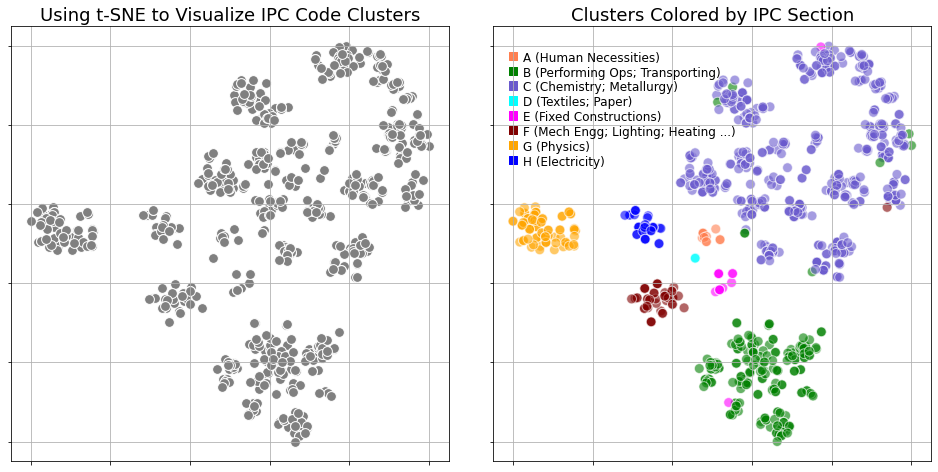

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16.5, 8))

df2.plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', color='gray', edgecolors='white', s=96, grid=True)
axes[0].set_title('Using t-SNE to Visualize IPC Code Clusters', fontsize=18)
decorate(axes[0], None, None)

#colors = [cmap[section] if section in cmap else 'red' for section in df2['ipcs_sentence'].str[0]]
colors = ipc_color(df2)
df2.plot.scatter(ax=axes[1], x='tsne_x', y='tsne_y', alpha=0.6, color=colors, edgecolors='white', s=96)
axes[1].set_title('Clusters Colored by IPC Section', fontsize=18)
decorate(axes[1], cmap, 80, fontsize=12)

fig.subplots_adjust(wspace=0.1)

None

<h3>7.2 Drilling down into the Clusters (Hierarchic Classification)</h3>

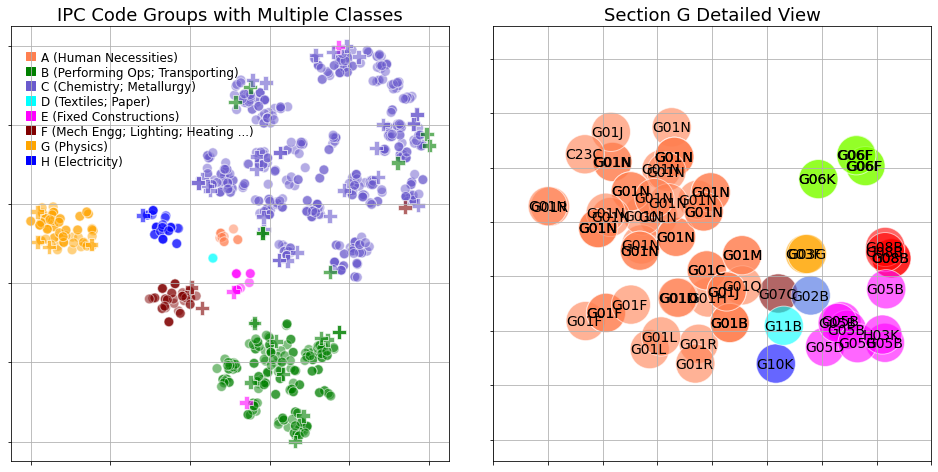

In [13]:
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16.5, 8))

#
#    First graph
#

one_ipc = [len(set([ipc[0] for ipc in ipc3.split()])) == 1 for ipc3 in df2['ipcs_sentence']]
two_ipc = [len(set([ipc[0] for ipc in ipc3.split()])) == 2 for ipc3 in df2['ipcs_sentence']]
more_ipc = [len(set([ipc[0] for ipc in ipc3.split()])) > 2 for ipc3 in df2['ipcs_sentence']]

#colors = [cmap[section] if section in cmap else 'red' for section in df2[one_ipc]['ipc'].str[0]]
colors = ipc_color(df2[one_ipc])
df2[one_ipc].plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', 
    alpha=0.5, color=colors, edgecolors='white', s=96, grid=True)

#colors = [cmap[section] if section in cmap else 'red' for section in df2[two_ipc]['ipc'].str[0]]
colors = ipc_color(df2[two_ipc])
df2[two_ipc].plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', alpha=0.6, color=colors, 
    edgecolors='white', marker='P', s=192, grid=True)

#colors = [cmap[section] if section in cmap else 'red' for section in df2[more_ipc]['ipc'].str[0]]
colors = ipc_color(df2[more_ipc])
df2[more_ipc].plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', alpha=0.6, color=colors, 
    edgecolors='white', marker='X', s=192, grid=True)

decorate(axes[0], cmap, 80, fontsize=12)
axes[0].set_title('IPC Code Groups with Multiple Classes', fontsize=18)

#
#    Second graph
#

dfg = df2.query("tsne_x < 0.2")
axes[1].set_ylim(0.44, 0.64)
axes[1].set_xlim(-0.025, 0.175)
colors = {'G01': 'coral', 'G02': 'royalblue', 'G03': 'orange', 'G04': 'cyan', 'G05': 'magenta', 'G06': 'chartreuse', 
    'G07': 'maroon', 'G08': 'red', 'G10': 'blue', 'G11': 'cyan'}
classes = dfg['ipcs_sentence'].map(lambda sentence: [word[:3] for word in sentence.split() if len(word) >= 3])
most_common_class = classes.map(lambda a: Counter(a).most_common(1)[0][0])
color = [colors[cls] if cls in colors else 'white' for cls in most_common_class]
dfg.plot.scatter(ax=axes[1], x='tsne_x', y='tsne_y', alpha=0.6, color=color, 
    edgecolors='white', s=1536, grid=True)
for row in dfg[['tsne_x', 'tsne_y', 'ipc']].values:
  x, y, ipc = row[0], row[1], row[2]
  colors = {'01': 'red', '02': 'maroon', '03': 'blue', '04': 'cyan', '05': 'magenta', '06': 'green'}
  color = colors[ipc[1:3]] if ipc[1:3] in colors else 'black'
  axes[1].text(x - 0.009, y - 0.002, ipc[0:4], color='black', fontsize=14)
decorate(axes[1], None, None)
axes[1].set_title('Section G Detailed View', fontsize=18)

fig.subplots_adjust(wspace=0.1)

None

<h2>8. The evolution of IPC Codes</h2>

In [14]:
import matplotlib.pyplot as plt

def twin_charts(year):
  fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16.5, 8))
  axes = axes.ravel()

  for ax, base_year in zip(axes, [year, year + 2]):

    futuredf = df2.query("publicationDate >= '%d-01-01'" % (base_year + 2))
    futuredf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='white', edgecolors='gray', alpha=0.7, s=96)

    pastdf = df2.query("publicationDate < '%d-01-01'" % base_year)
    pastdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='gray', edgecolors='white', alpha=0.5, s=96)

    currentdf = df2.query("publicationDate >= '%d-01-01' and publicationDate < '%d-01-01'" % (base_year, base_year + 2))
    colors = [cmap[section] if section in cmap else 'red' for section in currentdf['ipc'].str[0]]
    colors = ipc_color(currentdf)
    currentdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color=colors, edgecolors='white', alpha=0.7, s=96)

    ax.set_title('%d and %d' % (base_year, base_year + 1), fontsize=14)
  
    decorate(ax, cmap, 80, fontsize=12)

  fig.subplots_adjust(wspace=0.1, hspace=0.1)

<h3>8.1 From 2008 to 2011</h3>

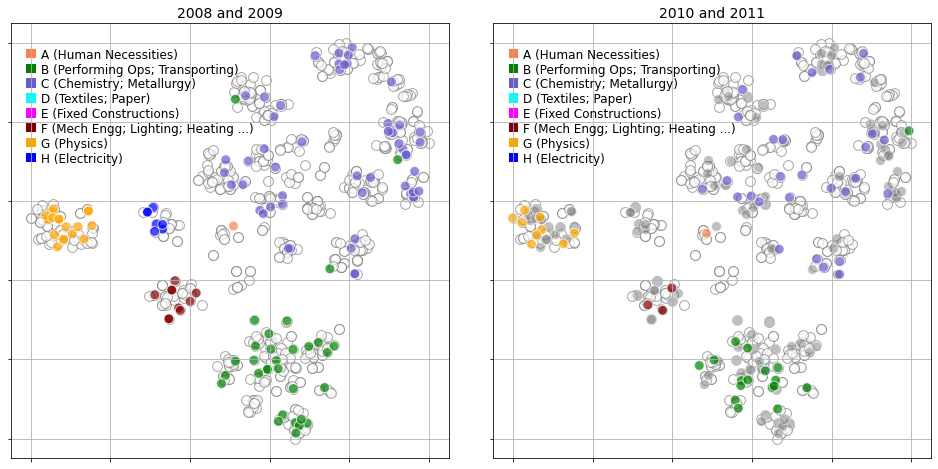

In [15]:
twin_charts(2008)

<h3>8.2 From 2012 to 2015</h3>

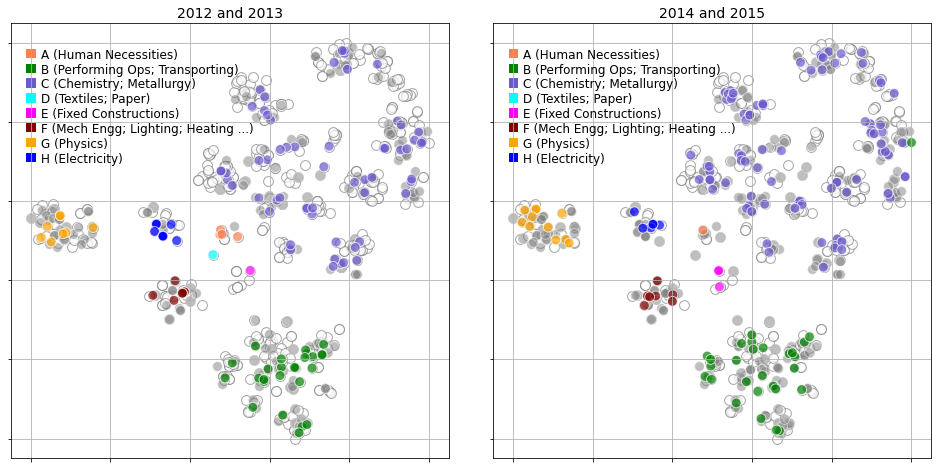

In [16]:
twin_charts(2012)

<h3>8.1 From 2016 to 2019</h3>

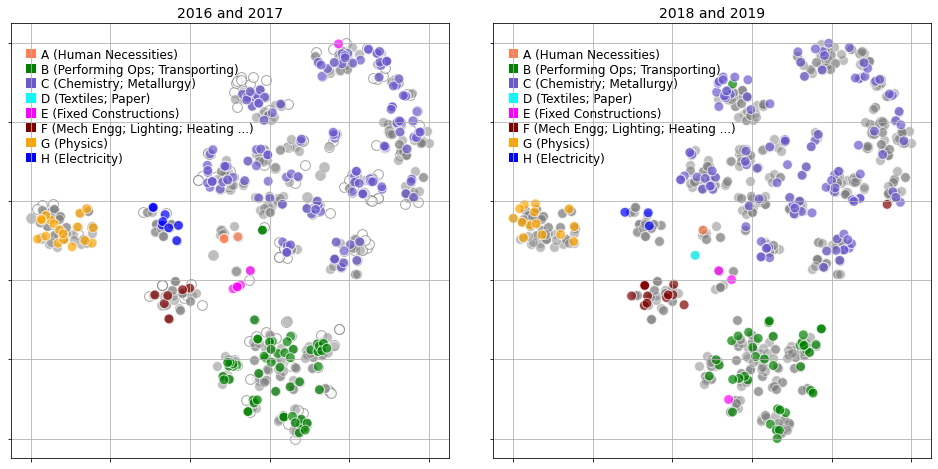

In [17]:
twin_charts(2016)

<h2>9. All 6 Charts Together</h2>

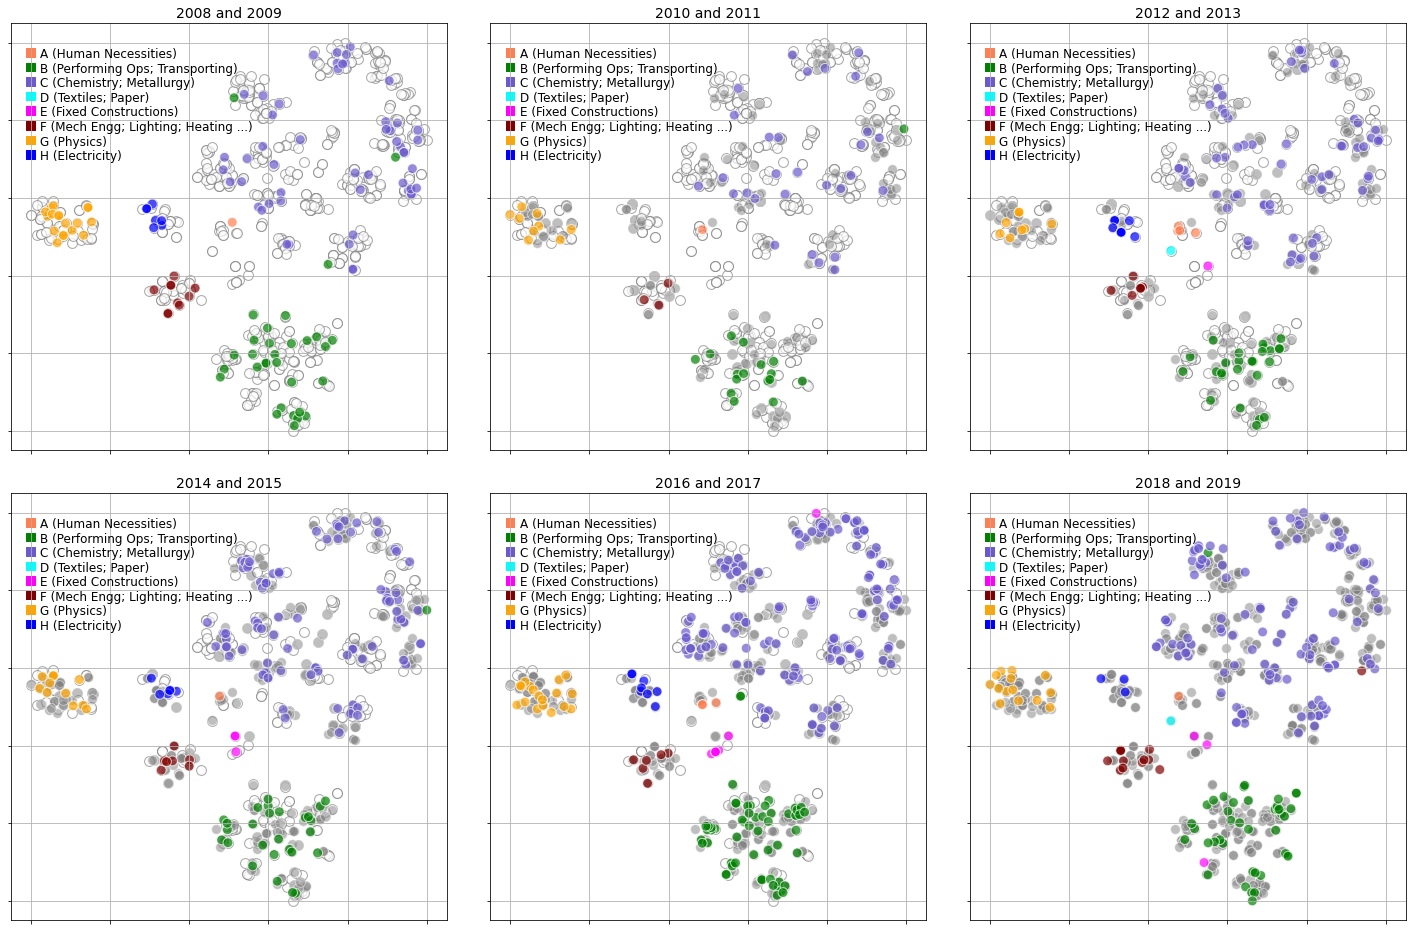

In [18]:
import matplotlib.pyplot as plt

fig, axes23 = plt.subplots(2, 3, sharey=True, figsize=(25, 16.5))
axes = axes23.ravel()

for ax, base_year in zip(axes, range(2008, 2019, 2)):

  futuredf = df2.query("publicationDate >= '%d-01-01'" % (base_year + 2))
  futuredf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='white', edgecolors='gray', alpha=0.7, s=96)

  pastdf = df2.query("publicationDate < '%d-01-01'" % base_year)
  pastdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='gray', edgecolors='white', alpha=0.5, s=96)

  currentdf = df2.query("publicationDate >= '%d-01-01' and publicationDate < '%d-01-01'" % (base_year, base_year + 2))
  colors = [cmap[section] if section in cmap else 'red' for section in currentdf['ipc'].str[0]]
  colors = ipc_color(currentdf)
  currentdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color=colors, edgecolors='white', alpha=0.7, s=96)

  ax.set_title('%d and %d' % (base_year, base_year + 1), fontsize=14)
  
  decorate(ax, cmap, 80, fontsize=12)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

None